In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import _generate_hypercube
from sklearn.utils import check_random_state
from sklearn.utils import shuffle as util_shuffle

sklearn's make_classification  
https://github.com/scikit-learn/scikit-learn/blob/7813f7efb/sklearn/datasets/samples_generator.py#L36  
素晴らしい解説サイト  
http://overlap.hatenablog.jp/entry/2015/10/08/022246

Parameters
----------
- n_samples: サンプル数
- n_features: 特徴量数。n_features >= n_informative + n_redundant + n_repeated
- n_informative: クラスタ頂点位置を中心として生成される多変量正規分布の次元数（特徴量数）
- n_redundant: informative特徴量の線形結合から生成される特徴量の数
- n_repeated: informative特徴量、redundant特徴量のコピーからなる特徴量の数
- n_classes: クラス数（本コンペでは2）
- n_clusters_per_class: 1クラスあたりのクラスタ数
- weights: 各クラスのサンプル数の比率（本コンペではNone）
- class_sep: 各クラスタの頂点位置の距離
- hypercube: Trueにすると、超立方体(hypercube)の頂点にクラスタを配置する。Falseにするとrandom polytope(わからん)の頂点にクラスタが配置される。
- shift: 全ての特徴量に対するシフト量
- scale: 全ての特徴量に対するスケーリングの割合
- flip_y: フリップの割合
- shuffle: Trueにすると行と列がシャッフルされる

In [2]:
x, y = make_classification(
    n_samples=3000, n_features=2, n_classes=2,
    n_informative=2, n_redundant=0, n_repeated=0,
    class_sep=4, shuffle=False, flip_y=0.05,
    scale=1, shift=0, hypercube=True, weights=None,
    n_clusters_per_class=2
)
print(x.shape, y.shape)

(3000, 2) (3000,)


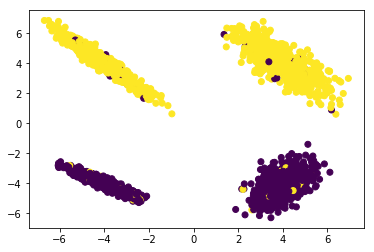

In [3]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

## 以下、実装の内容を追跡

パラメータ値

In [4]:
n_samples = 100
n_features = 20
n_informative = 2
n_redundant = 2
n_repeated = 1
n_classes = 2
n_clusters_per_class = 2
weights = None
random_state = 71
class_sep = 1
hypercube = True
flip_y = 0.05
shift = 0.0
scale = 1.0
shuffle = False

generatorの作成  
- np.random.RandomState
https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.RandomState.html

In [5]:
generator = check_random_state(random_state)
print(type(generator))
print(generator.randn(10))

<class 'mtrand.RandomState'>
[-0.43060315 -1.19392809 -0.44429899  0.48941221 -0.45155715  0.58569596
  1.17731982 -0.96500906  0.21827791 -0.86614368]


パラメータ算出
- n_useless: 余りの特徴量数。後ほど、この数だけ乱数を生成して特徴量に加える（ノイズ）
- n_clusters: クラスタの総数

In [6]:
n_useless = n_features - n_informative - n_redundant - n_repeated
n_clusters = n_classes * n_clusters_per_class
print(n_useless, n_clusters)

15 4


クラスの比率を決める。
- n_classes=2でweights=Noneならば、0と1が50%ずつ
- n_classes=2で[0.9, 0.1]と与えると、0が90%, 1が10%となる

In [7]:
if weights and len(weights) == (n_classes - 1):
    weights = weights + [1.0 - sum(weights)]

if weights is None:
    weights = [1.0 / n_classes] * n_classes
    weights[-1] = 1.0 - sum(weights[:-1])

print(weights)

[0.5, 0.5]


各クラスタに属するサンプル数を決める
- 上記のweightsでn_sampleを各クラスタに配分する
- n_samples=100でn_clusters=4, weights=[0.5, 0.5]なら、[25, 25, 25, 25]でサンプルが分配される

In [8]:
# Distribute samples among clusters by weight
n_samples_per_cluster = [
    int(n_samples * weights[k % n_classes] / n_clusters_per_class)
    for k in range(n_clusters)]

for i in range(n_samples - sum(n_samples_per_cluster)):
    n_samples_per_cluster[i % n_clusters] += 1

print(n_samples_per_cluster)

[25, 25, 25, 25]


説明変数、目的変数の初期化

In [9]:
# Initialize X and y
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples, dtype=np.int)
print(X.shape, y.shape)

(100, 20) (100,)


クラスタの頂点位置を決める
- n_informative次元で、各クラスタの頂点位置を決める。 shape=(n_clusters, n_informative)
- 各頂点位置が±class_sepの距離になるよう修正する。

In [10]:
# Build the polytope whose vertices become cluster centroids
centroids = _generate_hypercube(n_clusters, n_informative, generator).astype(float, copy=False)
print(centroids)

centroids *= 2 * class_sep
centroids -= class_sep
print(centroids)
print(centroids.shape)

if not hypercube:
    centroids *= generator.rand(n_clusters, 1)
    centroids *= generator.rand(1, n_informative)

[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]
(4, 2)


informative特徴量の作成
- 始めにN(0, 1)に従う乱数を生成する。shape=(n_samples, n_informative)
- 各クラスタ頂点位置毎にループする。
    - 各クラスタに割り振られたサンプルの数だけ、informative特徴量を切り出す （X_k）
    - informative特徴量に対して、[-1, 1]の一様分布から生成された行列をかけることで、informative特徴量間の相関を高くする（共分散を与える）
    - informative特徴量の平均値をクラスタ頂点位置にシフトさせる

In [11]:
# Initially draw informative features from the standard normal
X[:, :n_informative] = generator.randn(n_samples, n_informative)

# Create each cluster; a variant of make_blobs
stop = 0
for k, centroid in enumerate(centroids):
    start, stop = stop, stop + n_samples_per_cluster[k]
    print(k, centroid, n_samples_per_cluster[k])

    y[start:stop] = k % n_classes  # assign labels
    X_k = X[start:stop, :n_informative]  # slice a view of the cluster
    print(np.corrcoef(X_k[:, 0], X_k[:, 1])[0, 1])

    A = 2 * generator.rand(n_informative, n_informative) - 1
    X_k[...] = np.dot(X_k, A)  # introduce random covariance
    print(np.corrcoef(X_k[:, 0], X_k[:, 1])[0, 1])

    X_k += centroid  # shift the cluster to a vertex
    print(X_k.mean(axis=0), "\n")

0 [-1. -1.] 25
-0.2449412636660611
0.18868627481550224
[-1.0011703  -1.05908435] 

1 [-1.  1.] 25
0.19078344197519187
0.3883152663326104
[-1.15423056  0.99173401] 

2 [ 1. -1.] 25
-0.24133472284922416
0.5648671258624557
[ 1.0865841  -0.97787982] 

3 [1. 1.] 25
0.1978961724781675
-0.9552196421296113
[0.9597106  1.08313719] 



redundant特徴量の作成
- informative特徴量に対して、[-1, 1]の一様分布から生成された行列をかけることで、redundant特徴量を作成する

In [12]:
# Create redundant features
if n_redundant > 0:
    B = 2 * generator.rand(n_informative, n_redundant) - 1
    X[:, n_informative:n_informative + n_redundant] = \
        np.dot(X[:, :n_informative], B)

repeated特徴量の作成
- informative特徴量とredundant特徴量からランダムに選択する。

In [13]:
# Repeat some features
if n_repeated > 0:
    n = n_informative + n_redundant
    indices = ((n - 1) * generator.rand(n_repeated) + 0.5).astype(np.intp)
    X[:, n:n + n_repeated] = X[:, indices]

useless特徴量の作成
- 余った分の特徴量を作成する。N(0, 1)分布から乱数を生成する。

In [14]:
# Fill useless features
if n_useless > 0:
    X[:, -n_useless:] = generator.randn(n_samples, n_useless)

flipする
- ラベルをflip_yに比率に応じてランダムにflipする。

In [15]:
# Randomly replace labels
if flip_y >= 0.0:
    flip_mask = generator.rand(n_samples) < flip_y
    y[flip_mask] = generator.randint(n_classes, size=flip_mask.sum())

特徴量に対してshiftとscaleを実行する
- すべての特徴量にshift分加算する
- すべての特徴量にscale分乗算する

In [16]:
# Randomly shift and scale
if shift is None:
    shift = (2 * generator.rand(n_features) - 1) * class_sep
X += shift

if scale is None:
    scale = 1 + 100 * generator.rand(n_features)
X *= scale

行と列をシャッフルする
- レコードの順序をシャッフルする（行方向）
- 特徴量の順序をシャッフルする（列方向）

In [17]:
if shuffle:
    # Randomly permute samples
    X, y = util_shuffle(X, y, random_state=generator)

    # Randomly permute features
    indices = np.arange(n_features)
    generator.shuffle(indices)
    X[:, :] = X[:, indices]